In [65]:
!pip install gymnasium

In [66]:
import numpy as np
import gymnasium as gym
import matplotlib.pyplot as plt
import random
from IPython.display import clear_output

In [67]:
#!pip install --upgrade ptan torch
import torch
import torch.nn as nn
import copy
from collections import deque
from tqdm import tqdm

In [68]:
env=gym.make('CartPole-v1',render_mode='rgb_array')
env.reset()

(array([ 0.03584863, -0.02801725, -0.03498011,  0.03678349], dtype=float32),
 {})

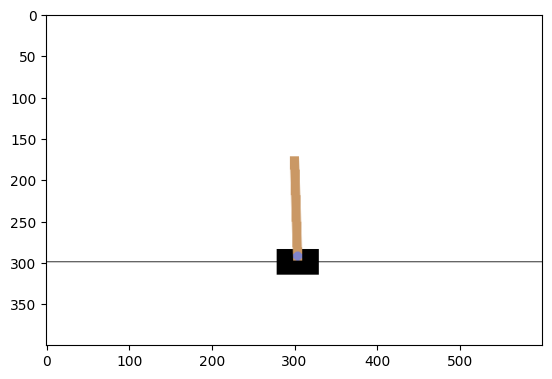

In [69]:
plt.imshow(env.render())

In [70]:
env.action_space

Discrete(2)

In [71]:
env.observation_space

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)

In [72]:
env.step(0)

(array([ 0.03528828, -0.22262058, -0.03424444,  0.31822786], dtype=float32),
 1.0,
 False,
 False,
 {})

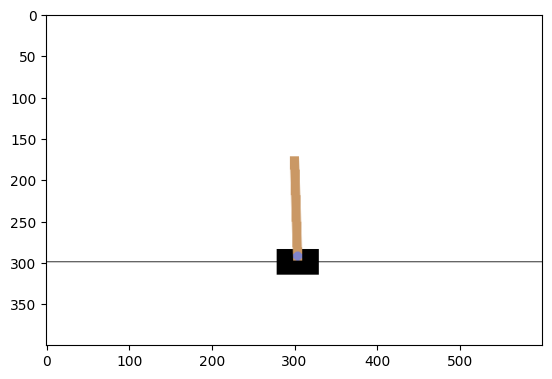

In [73]:
plt.imshow(env.render())

In [74]:
n_s=4
n_a=2
n_epi=1000
dics=.99
n_t=200

In [75]:
def get_bat(tau):
  s_bat=torch.Tensor([s for (s,a,r) in tau])
  a_bat=torch.Tensor([a for (s,a,r) in tau]).long()
  r_bat=torch.Tensor([r for (s,a,r) in tau])
  return s_bat,a_bat,r_bat

In [76]:
def get_Gt_bat(r_bat,disc=0.99):
  Gt_bat=torch.zeros_like(r_bat)
  Gt=0.0
  for t in reversed(range(len(r_bat))):
    Gt=r_bat[t]+disc*Gt
    Gt_bat[t]=Gt
  return Gt_bat

In [77]:
h1=50

In [78]:
Pi_net=torch.nn.Sequential(
  torch.nn.Linear(n_s,h1),
  torch.nn.ReLU(),
  torch.nn.Linear(h1,n_a),
  torch.nn.Softmax(dim=1)
)

In [79]:
losses=[]

In [80]:
def loss_fn(pi_bat,Gt_bat):
  return -1*torch.sum(torch.log(pi_bat)*Gt_bat)

optimizer=torch.optim.Adam(Pi_net.parameters(),lr=1e-3)

In [81]:
env=gym.make('CartPole-v1',render_mode='rgb_array')
scores=[]

In [82]:
for i in range(n_epi):
  tau=[]
  s,_=env.reset()
  done=False
  while not done and len(tau)<n_t:
    Pi=Pi_net(torch.Tensor([s])).squeeze()
    a=np.random.choice(range(n_a),p=Pi.data.numpy())
    s1,r,done,_,_=env.step(a)
    tau.append((s,a,r))
    s=s1
  s_bat,a_bat,r_bat=get_bat(tau)
  Gt_bat=get_Gt_bat(r_bat)
  Pi_bat=Pi_net(s_bat)
  pi_bat=Pi_bat.gather(dim=1,index=a_bat.view(-1,1)).squeeze()
  loss=loss_fn(pi_bat,Gt_bat)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  scores.append(len(tau))
  print(i,loss.item(),scores[i])
  clear_output(wait=True)

999 6546.76220703125 200


Text(0, 0.5, 'Loss')

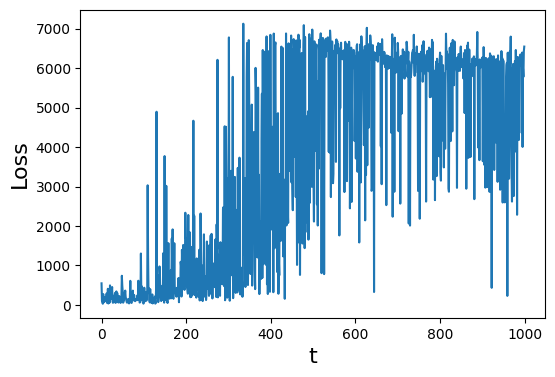

In [83]:
plt.figure(figsize=(6,4))
plt.plot(losses)
plt.xlabel("t",fontsize=16)
plt.ylabel("Loss",fontsize=16)

Text(0, 0.5, 'Score')

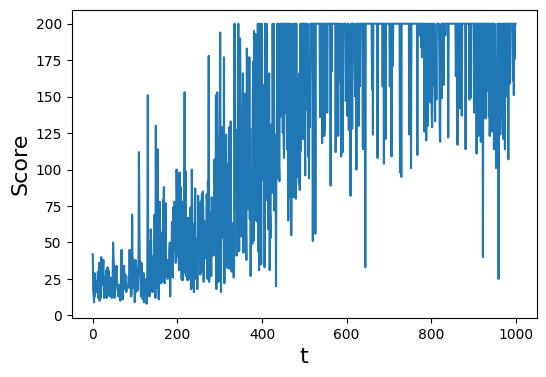

In [84]:
plt.figure(figsize=(6,4))
plt.plot(scores)
plt.xlabel("t",fontsize=16)
plt.ylabel("Score",fontsize=16)

In [85]:
def test_agent(model,n_t=200,mode='human',display=True):
  env=gym.make('CartPole-v1',render_mode=mode)
  s,_=env.reset()
  for t in range(n_t):
    Pi=Pi_net(torch.Tensor([s])).squeeze()
    a=np.random.choice(range(n_a),p=Pi.data.numpy())
    s1,r,done,_,_=env.step(a)
    if display:
      print('t=',t,'\n','s=',s,'\n','a=',a,'\n','r=',r,'\n','s\'=',s1,'\n','done=',done)
      clear_output(wait=True)
    s=s1
    if done:
      if display:
        print('You Score:%s'%(t+1))
      break
  if not done:
    if display:
      print('Your Score:%s'%(t+1))
  return t+1

In [86]:
test_agent(Pi_net)

Your Score:200


200

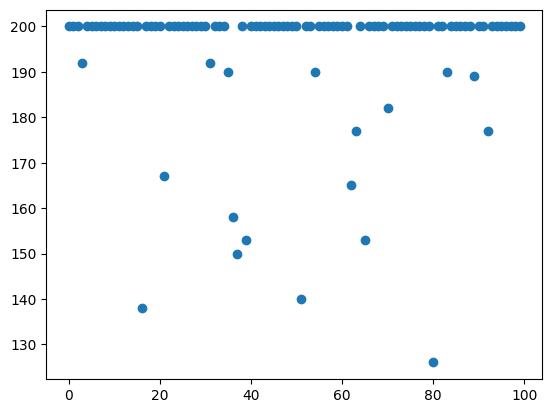

In [87]:
n_game=100
scores=[]
s,_=env.reset()
for i in range(n_game):
  score=test_agent(Pi_net,mode=None,display=False)
  scores.append(score)
plt.scatter(np.arange(len(scores)),scores)